In [1]:
from fastai.vision.all import *

from shapely.wkt import loads
from shapely.ops import clip_by_rect
from shapely.geometry import box
from tqdm import tqdm
import cv2
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.auto import tqdm

In [2]:
# PATH = Path("/data/")
PATH = Path('///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/')

In [3]:
PATH.ls()

(#10) [Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/coco_annotations'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images.zip'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images_bboxes.csv'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/labels'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/SampleSubmission.csv'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/splits'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/Test.csv'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/test_images'),Path('/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/Train.csv')]

In [4]:
train = pd.read_csv(PATH/'Train.csv')
test  = pd.read_csv(PATH/'Test.csv')
sub   = pd.read_csv(PATH/'SampleSubmission.csv')

display_df(train.head())
display_df(test.head())
display_df(sub.head())

,image_id_worm,worm_type,number_of_worms
0,id_0002ea6f15c7fa6f4c221783.jpg,pbw,51
1,id_0005ef295aafe6acc63587db.jpg,pbw,8
2,id_00084298dd030a500033ff78.jpg,NaN,0
3,id_00093f2c76f6488737325859.jpg,pbw,12
4,id_000b2e6c437c643f25d4a6c3.jpg,pbw,87


,image_id_worm
0,id_00332970f80fa9a47a39516d.jpg
1,id_0035981bc3ae42eb5b57a317.jpg
2,id_005102f664b820f778291dee.jpg
3,id_0066456f5fb2cd858c69ab39.jpg
4,id_007159c1fa015ba6f394deeb.jpg


,image_id_worm,number_of_worms
0,id_00332970f80fa9a47a39516d_abw,0
1,id_00332970f80fa9a47a39516d_pbw,0
2,id_0035981bc3ae42eb5b57a317_abw,0
3,id_0035981bc3ae42eb5b57a317_pbw,0
4,id_005102f664b820f778291dee_abw,0


In [5]:
train.shape, len(train.image_id_worm.unique())

((9900, 3), 9737)

In [6]:
counts = train.groupby('image_id_worm')['number_of_worms'].agg("sum")
counts.head()

image_id_worm
id_0002ea6f15c7fa6f4c221783.jpg    51
id_0005ef295aafe6acc63587db.jpg     8
id_00084298dd030a500033ff78.jpg     0
id_00093f2c76f6488737325859.jpg    12
id_000b2e6c437c643f25d4a6c3.jpg    87
Name: number_of_worms, dtype: int64

In [7]:
len(counts)

9737

In [8]:
bboxes = pd.read_csv(PATH/'images_bboxes.csv')
bboxes['worm_type'] = bboxes['worm_type'].fillna('none')
bboxes.head()

,image_id,worm_type,geometry
0,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((2478.89 156.77, 2478.89 297.86, 2377.97 297.86, 2377.97 156.77, 2478.89 156.77))"
1,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((939.8199999999999 1221.46, 939.8199999999999 1319.68, 715.39 1319.68, 715.39 1221.46, 939.8199999999999 1221.46))"
2,id_8ada71185e18dc8838b4925b.jpg,abw,"POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129.73 1966.3, 1129.73 1558.06, 1559.7 1558.06))"
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,"POLYGON ((2090.216399557101 1537.2100674812148, 2090.216399557101 1799.8148571754284, 1743.6762822479086 1799.8148571754284, 1743.6762822479086 1537.2100674812148, 2090.216399557101 1537.2100674812148))"
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,"POLYGON ((2342.2568587778546 1676.3042504645477, 2342.2568587778546 1952.269926004185, 2162.1375666483864 1952.269926004185, 2162.1375666483864 1676.3042504645477, 2342.2568587778546 1676.3042504645477))"


In [9]:
unique_ids = bboxes.image_id.unique()

In [10]:
def load_bbox(bb_string,h,w):
    bounding_box = loads(str(bb_string))
    x1, y1, x2, y2 = bounding_box.bounds
    x1, y1, x2, y2 = np.clip(x1, 0, w), np.clip(y1, 0, h), np.clip(x2, 0, w), np.clip(y2, 0, h)
    return x1, y1, x2, y2

## Visualization

In [11]:
all_images = []
all_titles = []

for i in range(2):
    sample_id = np.random.choice(unique_ids)
    all_titles.append(sample_id)
    
    sample_path = PATH / f"images/{sample_id}"
    sample_img = cv2.cvtColor(cv2.imread(str(sample_path)), cv2.COLOR_BGR2RGB)
    height, width, channels = sample_img.shape

    sample_bboxes_df = bboxes.loc[bboxes.image_id == sample_id].reset_index(drop=True, inplace=False)

    sample_bboxes = []
    for _, val in sample_bboxes_df.iterrows():
        bbox_string, class_id = val['geometry'], val['worm_type']
        
        if class_id != 'none':
            x1, y1, x2, y2 = load_bbox(bbox_string, height, width)
            sample_bboxes.append([x1, y1, x2, y2, class_id])

    for bbox in sample_bboxes:
        coord = (int(bbox[0]), int(bbox[1])), (int(bbox[2]),  int(bbox[3]))
        cv2.rectangle(sample_img, *coord, (119, 11, 32), 2)
        
    all_images.append(sample_img)

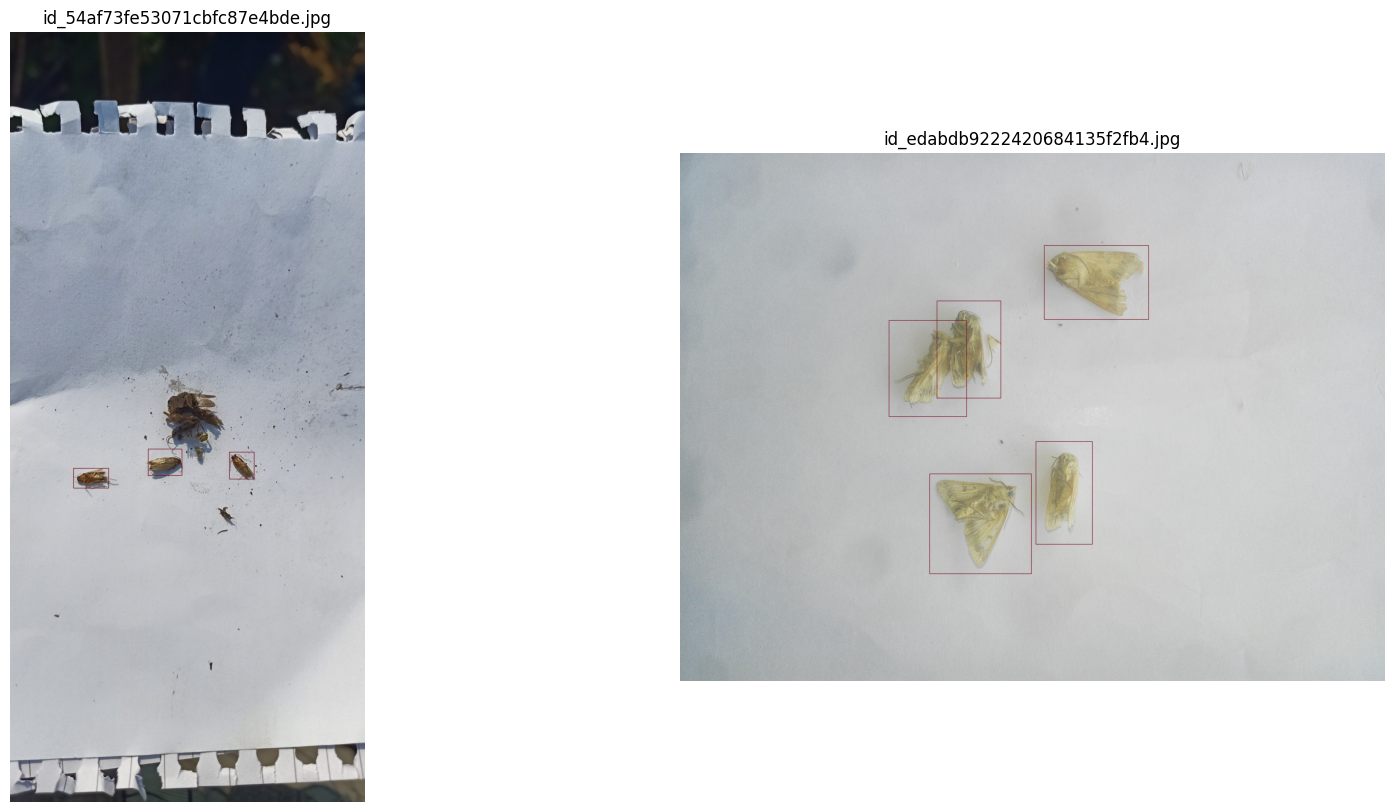

In [12]:
show_images(all_images, titles=all_titles, imsize=10)

## Create Folds

In [13]:
# select all the non empty images
select_non_empty_images = bboxes[bboxes.worm_type!='none']
select_non_empty_images = select_non_empty_images.image_id.values.tolist()
select_non_empty_images = L(set(select_non_empty_images))
select_non_empty_images

(#6479) ['id_a33854af2d82f25538ebcc64.jpg','id_f899c3eeb1871d6be3f58144.jpg','id_baa2f04ad2d3eab743ee4620.jpg','id_db448ecdbd032dc4dacdeca0.jpg','id_bb118085eecdbcde7b0525fd.jpg','id_2b9c8a3dedeac2a3eb6ed659.jpg','id_8c2fe8b14b6bf1b05b291c88.jpg','id_fb483c9bfc0526554267bbf7.jpg','id_cf7906343d62e6cd3b535f9a.jpg','id_34db8ad84a63a4d81c7ded1c.jpg'...]

In [14]:
# select a small subset of empty images
print(bboxes[bboxes.worm_type=='none'].shape)
select_empty_images = bboxes[bboxes.worm_type=='none'].sample(n=600, random_state=42)
select_empty_images = select_empty_images.image_id.values.tolist()
select_empty_images = L(set(select_empty_images))
select_empty_images

(3258, 3)


(#600) ['id_d67754c4c284435617beef4a.jpg','id_4540a0d5892421b82e256a6b.jpg','id_2a0943fdfc93b85b5972e2e8.jpg','id_bb3593ef3b0b9163870a197b.jpg','id_e53020f25e3cd973fcd11276.jpg','id_04debd8710e36cd5ddb76597.jpg','id_3d6603aa6290730db1899902.jpg','id_6cc67d3570fb965333fc066c.jpg','id_68670a6510ab0083d0ef462b.jpg','id_ace4d95273442167817e5749.jpg'...]

In [15]:
select_images = select_non_empty_images + select_empty_images
select_images

(#7079) ['id_a33854af2d82f25538ebcc64.jpg','id_f899c3eeb1871d6be3f58144.jpg','id_baa2f04ad2d3eab743ee4620.jpg','id_db448ecdbd032dc4dacdeca0.jpg','id_bb118085eecdbcde7b0525fd.jpg','id_2b9c8a3dedeac2a3eb6ed659.jpg','id_8c2fe8b14b6bf1b05b291c88.jpg','id_fb483c9bfc0526554267bbf7.jpg','id_cf7906343d62e6cd3b535f9a.jpg','id_34db8ad84a63a4d81c7ded1c.jpg'...]

In [16]:
bboxes = bboxes.query("image_id in @select_images")
bboxes = bboxes.reset_index(drop=True, inplace=False)
bboxes.head()

,image_id,worm_type,geometry
0,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((2478.89 156.77, 2478.89 297.86, 2377.97 297.86, 2377.97 156.77, 2478.89 156.77))"
1,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((939.8199999999999 1221.46, 939.8199999999999 1319.68, 715.39 1319.68, 715.39 1221.46, 939.8199999999999 1221.46))"
2,id_8ada71185e18dc8838b4925b.jpg,abw,"POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129.73 1966.3, 1129.73 1558.06, 1559.7 1558.06))"
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,"POLYGON ((2090.216399557101 1537.2100674812148, 2090.216399557101 1799.8148571754284, 1743.6762822479086 1799.8148571754284, 1743.6762822479086 1537.2100674812148, 2090.216399557101 1537.2100674812148))"
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,"POLYGON ((2342.2568587778546 1676.3042504645477, 2342.2568587778546 1952.269926004185, 2162.1375666483864 1952.269926004185, 2162.1375666483864 1676.3042504645477, 2342.2568587778546 1676.3042504645477))"


In [17]:
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

bboxes['kfold'] = -1
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(bboxes, y=bboxes.worm_type.values, groups=bboxes.image_id.values)):
    print(f"TRAIN: {train_idx}  TEST: {val_idx}")
    bboxes.loc[val_idx, 'kfold'] = fold_idx

TRAIN: [     3      4      5 ... 137572 137573 137574]  TEST: [     0      1      2 ... 136837 136838 136839]
TRAIN: [     0      1      2 ... 137415 137416 137417]  TEST: [    15     16     17 ... 137572 137573 137574]
TRAIN: [     0      1      2 ... 137572 137573 137574]  TEST: [    24     25     26 ... 137415 137416 137417]
TRAIN: [     0      1      2 ... 137572 137573 137574]  TEST: [     3      4      5 ... 137229 137230 137231]
TRAIN: [     0      1      2 ... 137572 137573 137574]  TEST: [     6      7      8 ... 136599 136600 136601]


In [18]:
bboxes.to_csv(PATH/'train_folds.csv', index=False)

In [19]:
os.makedirs(PATH/'splits/', exist_ok=True)

In [20]:
for fold in range(5):
    ids = bboxes.query('kfold==@fold').image_id.unique()
    with (PATH/f'splits/fold{fold}.txt').open('w') as fp:
        fp.write("\n".join([os.path.join(PATH, 'images', o) for o in ids]))

## Convert to COCO Annotations

In [21]:
now = datetime.now()
class_name_to_id = {}
labels= ['abw', 'pbw']

data = dict(
    info=dict(description="COCO ANNOTATIONS", url=None, version=None, year=now.year, contributor=None, date_created=now.strftime("%Y-%m-%d %H:%M:%S.%f")),
    licenses=[dict(url=None, id=0, name=None)],
    images=[],
    type="instances",
    annotations=[],
    categories=[],
)

for class_id, each_label in enumerate(labels):
    class_name = each_label
    class_name_to_id[class_name] = class_id
    data["categories"].append(dict(supercategory=None, id=class_id, name=class_name))

In [22]:
os.makedirs(PATH/'coco_annotations', exist_ok=True)

In [23]:
for fold in range(5):
    ids = bboxes[bboxes["kfold"] == fold].image_id.unique()

    print(f"\n=> Fold: {fold} images_count: {len(ids)}")

    out_file = PATH/f"coco_annotations/fold{fold}.json"

    coco_data = data.copy()
    coco_data["images"] = []
    coco_data["annotations"] = []

    for i, img_id in tqdm(enumerate(ids), total=len(ids), dynamic_ncols=True):

        sample_path = PATH / f"images/{img_id}"
        sample_img = cv2.cvtColor(cv2.imread(str(sample_path)), cv2.COLOR_BGR2RGB)
        height, width, channels = sample_img.shape
        
        coco_data["images"].append(dict(license=0, url=None, file_name=img_id, height=height, width=width, date_captured=None, id=i))

        img_annotations_df = bboxes.loc[bboxes.image_id == img_id].reset_index(drop=True, inplace=False)

        img_annotations = []

        for count, (_, row) in enumerate(img_annotations_df.iterrows()):

            bbox_string, class_id = row["geometry"], row["worm_type"]
                
            if class_id != "none":

                x_min, y_min, x_max, y_max = load_bbox(bbox_string, height, width)

                area = round((x_max - x_min) * (y_max - y_min), 1)
                bbox = [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]
                category_id = class_name_to_id[class_id]

                coco_data["annotations"].append(dict(id=len(coco_data["annotations"]), image_id=i, category_id=category_id, area=int(area), bbox=bbox, iscrowd=0))

    with open(out_file, "w") as f:
        json.dump(coco_data, f, indent=4)


=> Fold: 0 images_count: 1418


  0%|                                                                                          | 0/1418 [00:00…


=> Fold: 1 images_count: 1416


  0%|                                                                                          | 0/1416 [00:00…


=> Fold: 2 images_count: 1411


  0%|                                                                                          | 0/1411 [00:00…


=> Fold: 3 images_count: 1417


  0%|                                                                                          | 0/1417 [00:00…


=> Fold: 4 images_count: 1417


  0%|                                                                                          | 0/1417 [00:00…

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


## Convert to YOLOV5 Labels

In [24]:
# base_dir
    # images # (contains image files)
    # labels # (contains .txt files)
        
# Yolo expects the bounding box dimensions to be
# normalized to have values between 0 and 1.
        
# Label format in .txt file
# class x-center y-center width height
# E.g. 0 0.1 0.2 200 300

# Each label is on a new line, in the .txt file:
# 0 0.1 0.2 200 300
# 0 0.1 0.2 200 300

In [25]:
class_name_to_id

{'abw': 0, 'pbw': 1}

In [27]:
os.makedirs(PATH/'labels/')

In [28]:
select_non_empty_images

(#6479) ['id_a33854af2d82f25538ebcc64.jpg','id_f899c3eeb1871d6be3f58144.jpg','id_baa2f04ad2d3eab743ee4620.jpg','id_db448ecdbd032dc4dacdeca0.jpg','id_bb118085eecdbcde7b0525fd.jpg','id_2b9c8a3dedeac2a3eb6ed659.jpg','id_8c2fe8b14b6bf1b05b291c88.jpg','id_fb483c9bfc0526554267bbf7.jpg','id_cf7906343d62e6cd3b535f9a.jpg','id_34db8ad84a63a4d81c7ded1c.jpg'...]

In [29]:
all_ids = []
for fold in range(5):
    ids = bboxes[bboxes["kfold"] == fold].image_id.unique().tolist()
    all_ids += ids

for i, img_id in tqdm(enumerate(all_ids), total=len(all_ids), dynamic_ncols=True):
    if img_id in select_non_empty_images:

        sample_path = PATH / f"images/{img_id}"
        sample_img = cv2.cvtColor(cv2.imread(str(sample_path)), cv2.COLOR_BGR2RGB)
        height, width, channels = sample_img.shape

        img_annotations_df = bboxes.loc[bboxes.image_id == img_id].reset_index(drop=True, inplace=False)

        annotations = []
        for count, (_, row) in enumerate(img_annotations_df.iterrows()):

            bbox_string, class_id = row["geometry"], row["worm_type"]

            xmin, ymin, xmax, ymax = load_bbox(bbox_string, height, width)

            bbox_h = int(ymax - ymin)
            bbox_h = bbox_h / height
            bbox_w = int(xmax - xmin)
            bbox_w = bbox_w / width

            x_center = xmin + (bbox_w / 2)
            x_center = x_center / width
            y_center = ymin + (bbox_h / 2)
            y_center = y_center / height

            category_id = class_name_to_id[class_id]

            annotations.append([category_id, x_center, y_center, bbox_w, bbox_h])

        annotations = np.array(annotations)
        np.savetxt(PATH / f"labels/{img_id.replace('.jpg', '.txt')}", 
                   annotations, 
                   fmt=["%d", "%f", "%f", "%f", "%f"])

  0%|                                                                                          | 0/7079 [00:00…

Invalid SOS parameters for sequential JPEG


#### Coco to yolo

In [30]:
import glob
import os
import shutil
from pathlib import Path

import numpy as np
from PIL import ExifTags
from tqdm import tqdm

# Parameters
img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
vid_formats = ['mov', 'avi', 'mp4', 'mpg', 'mpeg', 'm4v', 'wmv', 'mkv']  # acceptable video suffixes

# Get orientation exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


def exif_size(img):
    # Returns exif-corrected PIL size
    s = img.size  # (width, height)
    try:
        rotation = dict(img._getexif().items())[orientation]
        if rotation in [6, 8]:  # rotation 270
            s = (s[1], s[0])
    except:
        pass

    return s


def split_rows_simple(file='../data/sm4/out.txt'):  # from utils import *; split_rows_simple()
    # splits one textfile into 3 smaller ones based upon train, test, val ratios
    with open(file) as f:
        lines = f.readlines()

    s = Path(file).suffix
    lines = sorted(list(filter(lambda x: len(x) > 0, lines)))
    i, j, k = split_indices(lines, train=0.9, test=0.1, validate=0.0)
    for k, v in {'train': i, 'test': j, 'val': k}.items():  # key, value pairs
        if v.any():
            new_file = file.replace(s, f'_{k}{s}')
            with open(new_file, 'w') as f:
                f.writelines([lines[i] for i in v])


def split_files(out_path, file_name, prefix_path=''):  # split training data
    file_name = list(filter(lambda x: len(x) > 0, file_name))
    file_name = sorted(file_name)
    i, j, k = split_indices(file_name, train=0.9, test=0.1, validate=0.0)
    datasets = {'train': i, 'test': j, 'val': k}
    for key, item in datasets.items():
        if item.any():
            with open(f'{out_path}_{key}.txt', 'a') as file:
                for i in item:
                    file.write('%s%s\n' % (prefix_path, file_name[i]))


def split_indices(x, train=0.9, test=0.1, validate=0.0, shuffle=True):  # split training data
    n = len(x)
    v = np.arange(n)
    if shuffle:
        np.random.shuffle(v)

    i = round(n * train)  # train
    j = round(n * test) + i  # test
    k = round(n * validate) + j  # validate
    return v[:i], v[i:j], v[j:k]  # return indices


def make_dirs(dir='new_dir/'):
    # Create folders
    dir = Path(dir)
    if dir.exists():
        shutil.rmtree(dir)  # delete dir
    for p in dir, dir / 'labels', dir / 'images':
        p.mkdir(parents=True, exist_ok=True)  # make dir
    return dir


def write_data_data(fname='data.data', nc=80):
    # write darknet *.data file
    lines = ['classes = %g\n' % nc,
             'train =../out/data_train.txt\n',
             'valid =../out/data_test.txt\n',
             'names =../out/data.names\n',
             'backup = backup/\n',
             'eval = coco\n']

    with open(fname, 'a') as f:
        f.writelines(lines)


def image_folder2file(folder='images/'):  # from utils import *; image_folder2file()
    # write a txt file listing all imaged in folder
    s = glob.glob(f'{folder}*.*')
    with open(f'{folder[:-1]}.txt', 'w') as file:
        for l in s:
            file.write(l + '\n')  # write image list


def add_coco_background(path='../data/sm4/', n=1000):  # from utils import *; add_coco_background()
    # add coco background to sm4 in outb.txt
    p = f'{path}background'
    if os.path.exists(p):
        shutil.rmtree(p)  # delete output folder
    os.makedirs(p)  # make new output folder

    # copy images
    for image in glob.glob('../coco/images/train2014/*.*')[:n]:
        os.system(f'cp {image} {p}')

    # add to outb.txt and make train, test.txt files
    f = f'{path}out.txt'
    fb = f'{path}outb.txt'
    os.system(f'cp {f} {fb}')
    with open(fb, 'a') as file:
        file.writelines(i + '\n' for i in glob.glob(f'{p}/*.*'))
    split_rows_simple(file=fb)


def create_single_class_dataset(path='../data/sm3'):  # from utils import *; create_single_class_dataset('../data/sm3/')
    # creates a single-class version of an existing dataset
    os.system(f'mkdir {path}_1cls')


def flatten_recursive_folders(path='../../Downloads/data/sm4/'):  # from utils import *; flatten_recursive_folders()
    # flattens nested folders in path/images and path/JSON into single folders
    idir, jdir = f'{path}images/', f'{path}json/'
    nidir, njdir = Path(f'{path}images_flat/'), Path(f'{path}json_flat/')
    n = 0

    # Create output folders
    for p in [nidir, njdir]:
        if os.path.exists(p):
            shutil.rmtree(p)  # delete output folder
        os.makedirs(p)  # make new output folder

    for parent, dirs, files in os.walk(idir):
        for f in tqdm(files, desc=parent):
            f = Path(f)
            stem, suffix = f.stem, f.suffix
            if suffix.lower()[1:] in img_formats:
                n += 1
                stem_new = '%g_' % n + stem
                image_new = nidir / (stem_new + suffix)  # converts all formats to *.jpg
                json_new = njdir / f'{stem_new}.json'

                image = parent / f
                json = Path(parent.replace('images', 'json')) / str(f).replace(suffix, '.json')

                os.system("cp '%s' '%s'" % (json, json_new))
                os.system("cp '%s' '%s'" % (image, image_new))
                # cv2.imwrite(str(image_new), cv2.imread(str(image)))

    print('Flattening complete: %g jsons and images' % n)


def coco91_to_coco80_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, 24, 25, None,
         None, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, None, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, None, 60, None, None, 61, None, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         None, 73, 74, 75, 76, 77, 78, 79, None]
    return x

In [31]:
def convert_coco_json(json_dir=PATH/'coco_annotations', use_segments=False, cls91to80=False):
    save_dir = make_dirs(PATH/'yolo_new')  # output directory
    coco80 = coco91_to_coco80_class()

    # Import json
    for json_file in sorted(Path(json_dir).resolve().glob('*.json')):
        fn = Path(save_dir) / 'labels' / json_file.stem.replace('instances_', '')  # folder name
        fn.mkdir()
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}
        # Create image-annotations dict
        imgToAnns = defaultdict(list)
        for ann in data['annotations']:
            imgToAnns[ann['image_id']].append(ann)

        # Write labels file
        for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
            img = images['%g' % img_id]
            h, w, f = img['height'], img['width'], img['file_name']

            bboxes = []
            segments = []
            for ann in anns:
                if ann['iscrowd']:
                    continue
                # The COCO box format is [top left x, top left y, width, height]
                box = np.array(ann['bbox'], dtype=np.float64)
                box[:2] += box[2:] / 2  # xy top-left corner to center
                box[[0, 2]] /= w  # normalize x
                box[[1, 3]] /= h  # normalize y
                if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                    continue

                cls = coco80[ann['category_id'] - 1] if cls91to80 else ann['category_id']  # class
                box = [cls] + box.tolist()
                if box not in bboxes:
                    bboxes.append(box)
                # Segments
                if use_segments:
                    if len(ann['segmentation']) > 1:
                        s = merge_multi_segment(ann['segmentation'])
                        s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                    else:
                        s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                        s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                    s = [cls] + s
                    if s not in segments:
                        segments.append(s)

            # Write
            with open((fn / f).with_suffix('.txt'), 'a') as file:
                for i in range(len(bboxes)):
                    line = *(segments[i] if use_segments else bboxes[i]),  # cls, box or segments
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')


In [32]:
convert_coco_json()

Annotations /mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/coco_annotations/fold0.json: 100%|█| 1275/1275 [00:12<00
Annotations /mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/coco_annotations/fold1.json: 100%|█| 1292/1292 [00:14<00
Annotations /mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/coco_annotations/fold2.json: 100%|█| 1297/1297 [00:25<00
Annotations /mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/coco_annotations/fold3.json: 100%|█| 1322/1322 [00:34<00
Annotations /mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/coco_annotations/fold4.json: 100%|█| 1293/1293 [00:32<00


In [33]:
np.savetxt('///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/test.txt',pd.read_csv(PATH/'Test.csv'),fmt = '%s')


In [ ]:
#test_df = pd.read_csv(PATH/'Test.csv')

In [ ]:
# list(test_df['image_id_worm'])

In [ ]:
# import shutil
# import os

# src_dir = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'
# dst_dir = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/test_images'
# imageNames = list(test_df['image_id_worm'])
# for imageName in imageNames:
#     shutil.copy(os.path.join(src_dir, imageName), dst_dir)